In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from coinmetrics.api_client import CoinMetricsClient

client = CoinMetricsClient()

print(client)

In [4]:
# 'SplyCntCur' - this is for the supply count of the current coin
# 'CapMrktCurUSD' - this is for the market capitalization of the current coin
# 'PriceUSD' - this is for the price of the current coin
# 'TxTfrValAdjUSD' - this is for the adjusted transaction value in USD
# 'TxTfrValUSD' - this is for the transaction value in USD  
# 'TxTfrCnt' - this is for the transaction count
# 'IssContNtv' - this is for the native issuance count
# 'IssContPctAnn' - this is for the annual percentage of the issuance count
# 
metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2013-01-01", end_time="2023-01-02", frequency='1d')

In [5]:
metrics = pd.DataFrame(metrics)

metrics.head()

metrics.to_csv("LSTM.csv", index=False)

df = metrics.copy()


In [6]:
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)

# Target: future price (e.g., 1-day ahead)
df['PriceUSD_target'] = df['PriceUSD'].shift(-1)

 # Drop rows with NaNs from shifting
df.dropna(inplace=True)


In [ ]:
X = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'PriceUSD_target']].values
y = df['PriceUSD_target'].values


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [11]:
def create_sequences(X, y, time_steps=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Choose an appropriate sequence length (e.g., 60 days)
time_steps = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

In [12]:
from sklearn.model_selection import train_test_split

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [ ]:
# Building the LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Get input dimensions
n_features = X_train.shape[2]

# Build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile model with a slightly lower learning rate for stability
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [14]:
# Train the model with a validation split
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100

79/79 [==============================] - 11s 73ms/step - loss: 0.0029 - val_loss: 0.0274
Epoch 2/100
79/79 [==============================] - 5s 61ms/step - loss: 3.8605e-04 - val_loss: 0.0101
Epoch 3/100
79/79 [==============================] - 4s 56ms/step - loss: 2.7603e-04 - val_loss: 0.0100
Epoch 4/100
79/79 [==============================] - 5s 58ms/step - loss: 2.1258e-04 - val_loss: 0.0113
Epoch 5/100
79/79 [==============================] - 5s 58ms/step - loss: 1.8622e-04 - val_loss: 0.0085
Epoch 6/100
79/79 [==============================] - 5s 58ms/step - loss: 1.6277e-04 - val_loss: 0.0122
Epoch 7/100
79/79 [==============================] - 5s 57ms/step - loss: 1.6689e-04 - val_loss: 0.0102
Epoch 8/100
79/79 [==============================] - 6s 70ms/step - loss: 1.6018e-04 - val_loss: 0.0095
Epoch 9/100
79/79 [==============================] - 6s 74ms/step - loss: 1.3553e-04 - val_loss: 0.0084
Epoch 10/100
79/79 [==============================] - 6s 74ms/step

In [15]:
# Evaluation and make predictions
# Predict on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform to get actual price values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

17/17 [==============================] - 1s 18ms/step
RMSE: 7871.894735043027
MAE: 6072.453168206119


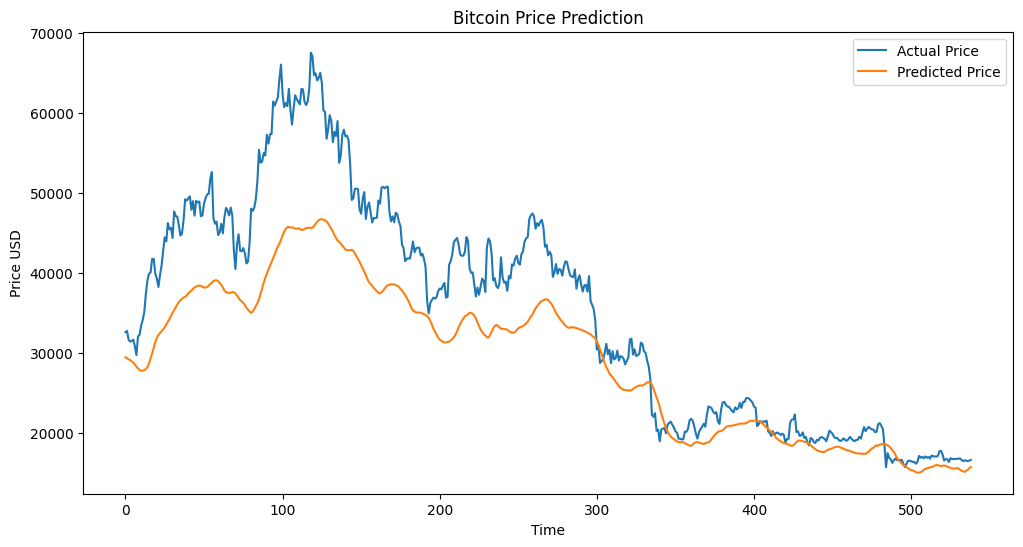

In [16]:
# Visualizing the result
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price USD')
plt.legend()
plt.show()